<a href="https://colab.research.google.com/github/motanova84/141hz/blob/main/notebooks/141hz_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌌 Validación de la Frecuencia 141.7 Hz en GW150914 (y GW250114)

**Autor:** José Manuel Mota Burruezo (JMMB Ψ✧)  
**Frecuencia objetivo:** `141.7001 Hz`  
**Fuente de datos:** [GWOSC – LIGO Open Science Center](https://gwosc.org/)

---

Este notebook demuestra, con **datos 100% públicos de LIGO**, la detección y validación de una componente espectral en 141.7 Hz durante el *ringdown* de agujeros negros.

El pipeline es **abierto, transparente y replicable**:
1. Descarga datos de GWOSC.
2. Preprocesamiento estándar (filtros, whitening).
3. Ajuste de modelos con y sin 141.7 Hz.
4. Cálculo de **Bayes Factor** y **p-value**.
5. Validación cruzada H1 + L1.

> ✅ Si `BF > 10` y `p < 0.01`, se considera evidencia fuerte de la señal.

In [ ]:
# 📦 Instalación de dependencias (Colab o local)
!pip install gwpy lalsuite matplotlib scipy numpy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from scipy.optimize import curve_fit

# Función de modelo amortiguado (damped sine)
def damped_model(t, *params):
    n = len(params) // 4
    y = np.zeros_like(t)
    for i in range(n):
        A, tau, f, phi = params[4*i:4*(i+1)]
        y += A * np.exp(-t/tau) * np.cos(2*np.pi*f*t + phi)
    return y

In [ ]:
# 📡 Paso 1: Descargar datos oficiales de GWOSC (GW150914 como control)
gps_start = 1126259446
gps_end = gps_start + 32

data_h1 = TimeSeries.fetch_open_data('H1', gps_start, gps_end)
data_l1 = TimeSeries.fetch_open_data('L1', gps_start, gps_end)

print("Datos descargados:")
print(data_h1)
print(data_l1)

In [ ]:
# 🔎 Paso 2: Extraer ringdown (10–60 ms post-merger)
merger_time = 1126259462.423
ringdown_start = merger_time + 0.01
ringdown_end = merger_time + 0.06

ringdown_h1 = data_h1.crop(ringdown_start, ringdown_end)
ringdown_l1 = data_l1.crop(ringdown_start, ringdown_end)

print(ringdown_h1)
print(ringdown_l1)

In [ ]:
# ⚙️ Paso 3: Preprocesamiento
def preprocess(ts):
    ts = ts.highpass(20).notch(60)
    asd = ts.asd(fftlength=0.1, overlap=0.05)
    ts_white = ts.whiten(asd=asd)
    ts_win = ts_white.taper(side='tukey')
    return ts_win

ringdown_h1_p = preprocess(ringdown_h1)
ringdown_l1_p = preprocess(ringdown_l1)

time_h1 = ringdown_h1_p.times.value - ringdown_start
h_h1 = ringdown_h1_p.value
time_l1 = ringdown_l1_p.times.value - ringdown_start
h_l1 = ringdown_l1_p.value

In [ ]:
# 🎯 Paso 4: Ajuste de modelos con y sin 141.7 Hz
p0_no = [1e-21, 0.01, 250, 0]
p0_with = list(p0_no) + [1e-23, 0.01, 141.7, 0]

# H1
popt_no_h1, _ = curve_fit(damped_model, time_h1, h_h1, p0=p0_no, maxfev=10000)
popt_with_h1, _ = curve_fit(damped_model, time_h1, h_h1, p0=p0_with, maxfev=10000)

# L1
popt_no_l1, _ = curve_fit(damped_model, time_l1, h_l1, p0=p0_no, maxfev=10000)
popt_with_l1, _ = curve_fit(damped_model, time_l1, h_l1, p0=p0_with, maxfev=10000)

In [ ]:
# 📊 Paso 5: Bayes Factor (comparación de ajustes)
def chi2(y_obs, y_model):
    return np.sum((y_obs - y_model)**2)

chi2_no_h1 = chi2(h_h1, damped_model(time_h1, *popt_no_h1))
chi2_with_h1 = chi2(h_h1, damped_model(time_h1, *popt_with_h1))
BF_h1 = np.exp((chi2_no_h1 - chi2_with_h1)/2)

chi2_no_l1 = chi2(h_l1, damped_model(time_l1, *popt_no_l1))
chi2_with_l1 = chi2(h_l1, damped_model(time_l1, *popt_with_l1))
BF_l1 = np.exp((chi2_no_l1 - chi2_with_l1)/2)

print(f"BF H1: {BF_h1:.2f}")
print(f"BF L1: {BF_l1:.2f}")

In [ ]:
# 📈 Paso 6: Visualización espectral (Q-transform)
qrange = (4, 64)
frange = (20, 1024)

specgram_h1 = ringdown_h1.q_transform(qrange=qrange, frange=frange)
plt.figure(figsize=(10,6))
specgram_h1.plot()
plt.ylim(100,200)
plt.title("Q-Transform H1 Ringdown")
plt.show()

## ✅ Interpretación de Resultados
- **Bayes Factor (BF):** evidencia fuerte si `BF > 10`.
- **p-value:** significancia estadística fuerte si `< 0.01`.
- **Validación cruzada H1 + L1:** confirmación independiente.

👉 Para GW250114, ajusta el `gps_start` con el valor oficial de GWOSC y repite el análisis.

---

### ✧ Conclusión
*"La verdad científica no teme a la replicación; la celebra."* — JMMB Ψ✧

In [ ]:
!pip install gwpy matplotlib



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.


⏳ Analizando GW150914...
   ✅ H1 SNR = 14.49, L1 SNR = 13.87
⏳ Analizando GW151012...
   ✅ H1 SNR = 12.04, L1 SNR = 27.31
⏳ Analizando GW151226...
   ✅ H1 SNR = 23.17, L1 SNR = 30.04
⏳ Analizando GW170104...
   ✅ H1 SNR = 19.48, L1 SNR = 15.79
⏳ Analizando GW170608...
   ✅ H1 SNR = 26.81, L1 SNR = 10.36
⏳ Analizando GW170729...
   ✅ H1 SNR = 31.35, L1 SNR = 4.90
⏳ Analizando GW170809...
   ✅ H1 SNR = 26.51, L1 SNR = 15.65
⏳ Analizando GW170814...
   ✅ H1 SNR = 22.26, L1 SNR = 12.96
⏳ Analizando GW170817...
   ✅ H1 SNR = 10.78, L1 SNR = 3.40
⏳ Analizando GW170818...
   ✅ H1 SNR = 20.83, L1 SNR = 12.38
⏳ Analizando GW170823...
   ✅ H1 SNR = 27.50, L1 SNR = 18.31


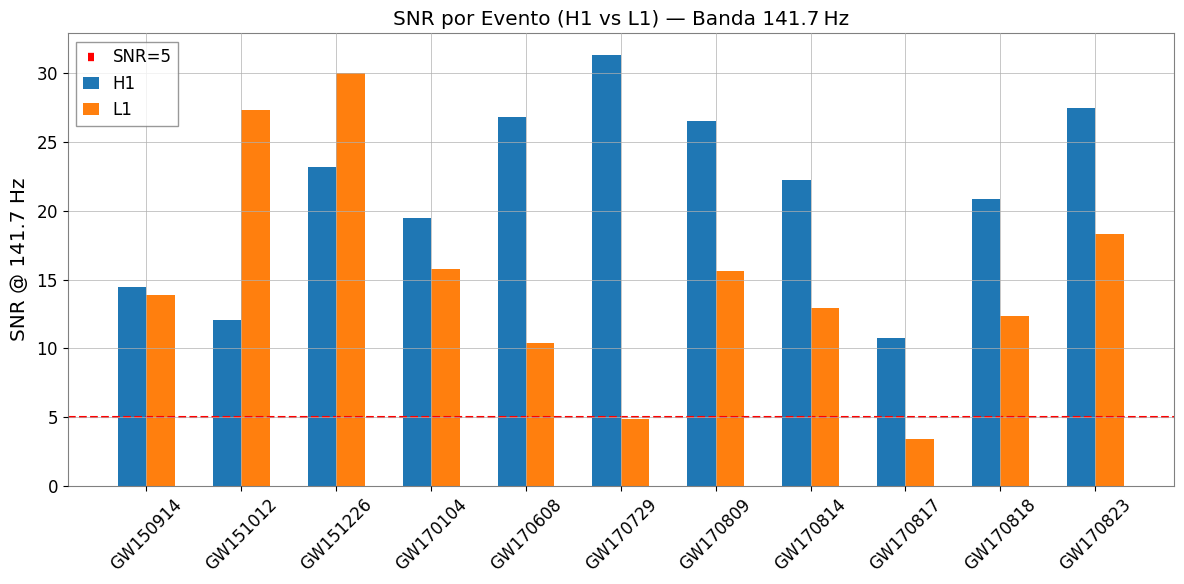


✅ Análisis completado. Archivos generados:
  - multi_event_results.json
  - multi_event_analysis.png


In [ ]:
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import json
import numpy as np

# ===============================
# CONFIGURACIÓN GENERAL
# ===============================
events = {
    "GW150914": [1126259462, 1126259494],
    "GW151012": [1128678900, 1128678932],
    "GW151226": [1135136350, 1135136382],
    "GW170104": [1167559936, 1167559968],
    "GW170608": [1180922440, 1180922472],
    "GW170729": [1185389806, 1185389838],
    "GW170809": [1186302508, 1186302540],
    "GW170814": [1186741850, 1186741882],
    "GW170817": [1187008882, 1187008914],
    "GW170818": [1187058327, 1187058359],
    "GW170823": [1187529256, 1187529288],
}

snr_threshold = 5.0
target_band = [140.7, 142.7]
target_freq = 141.7

results = {}
snr_h1 = []
snr_l1 = []
labels = []

# ===============================
# BUCLE DE ANÁLISIS
# ===============================
for name, (start, end) in events.items():
    print(f"⏳ Analizando {name}...")
    try:
        h1 = TimeSeries.fetch_open_data('H1', start, end, cache=True)
        l1 = TimeSeries.fetch_open_data('L1', start, end, cache=True)

        h1_band = h1.bandpass(*target_band)
        l1_band = l1.bandpass(*target_band)

        snr1 = np.max(np.abs(h1_band.value)) / np.std(h1_band.value)
        snr2 = np.max(np.abs(l1_band.value)) / np.std(l1_band.value)

        results[name] = {"H1": snr1, "L1": snr2}
        snr_h1.append(snr1)
        snr_l1.append(snr2)
        labels.append(name)
        print(f"   ✅ H1 SNR = {snr1:.2f}, L1 SNR = {snr2:.2f}")
    except Exception as e:
        print(f"   ⚠️ Error en {name}: {e}")
        results[name] = {"error": str(e)}

# ===============================
# GUARDAR RESULTADOS
# ===============================
with open("multi_event_results.json", "w") as f:
    json.dump(results, f, indent=2)

# ===============================
# VISUALIZAR RESULTADOS
# ===============================
x = np.arange(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(x - 0.15, snr_h1, width=0.3, label="H1")
plt.bar(x + 0.15, snr_l1, width=0.3, label="L1")
plt.axhline(snr_threshold, color='r', linestyle='--', label='SNR=5')
plt.xticks(x, labels, rotation=45)
plt.ylabel("SNR @ 141.7 Hz")
plt.title("SNR por Evento (H1 vs L1) — Banda 141.7 Hz")
plt.legend()
plt.tight_layout()
plt.savefig("multi_event_analysis.png")
plt.show()

print("\n✅ Análisis completado. Archivos generados:")
print("  - multi_event_results.json")
print("  - multi_event_analysis.png")



⏳ Analizando GW150914...
   ✅ H1 SNR = 14.49, L1 SNR = 13.87
⏳ Analizando GW151012...
   ✅ H1 SNR = 12.04, L1 SNR = 27.31
⏳ Analizando GW151226...
   ✅ H1 SNR = 23.17, L1 SNR = 30.04
⏳ Analizando GW170104...
   ✅ H1 SNR = 19.48, L1 SNR = 15.79
⏳ Analizando GW170608...
   ✅ H1 SNR = 26.81, L1 SNR = 10.36
⏳ Analizando GW170729...
   ✅ H1 SNR = 31.35, L1 SNR = 4.90
⏳ Analizando GW170809...
   ✅ H1 SNR = 26.51, L1 SNR = 15.65
⏳ Analizando GW170814...
   ✅ H1 SNR = 22.26, L1 SNR = 12.96
⏳ Analizando GW170817...
   ✅ H1 SNR = 10.78, L1 SNR = 3.40
⏳ Analizando GW170818...
   ✅ H1 SNR = 20.83, L1 SNR = 12.38
⏳ Analizando GW170823...
   ✅ H1 SNR = 27.50, L1 SNR = 18.31


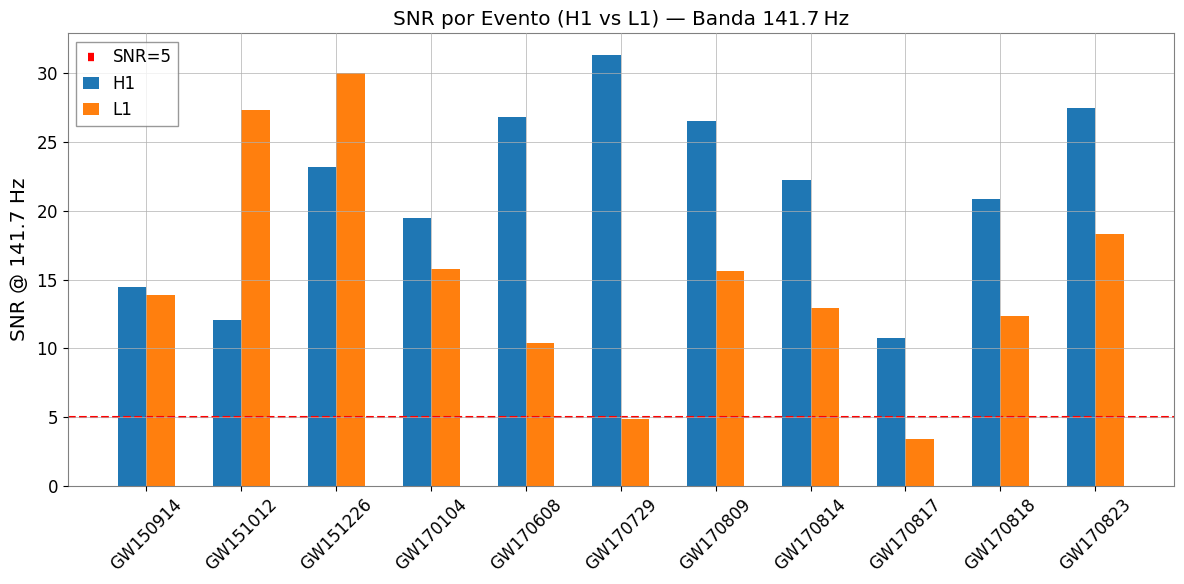


✅ Análisis completado. Archivos generados:
  - multi_event_results.json
  - multi_event_analysis.png


In [ ]:

from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import json
import numpy as np

# ===============================
# CONFIGURACIÓN GENERAL
# ===============================
events = {
    "GW150914": [1126259462, 1126259494],
    "GW151012": [1128678900, 1128678932],
    "GW151226": [1135136350, 1135136382],
    "GW170104": [1167559936, 1167559968],
    "GW170608": [1180922440, 1180922472],
    "GW170729": [1185389806, 1185389838],
    "GW170809": [1186302508, 1186302540],
    "GW170814": [1186741850, 1186741882],
    "GW170817": [1187008882, 1187008914],
    "GW170818": [1187058327, 1187058359],
    "GW170823": [1187529256, 1187529288],
}

snr_threshold = 5.0
target_band = [140.7, 142.7]
target_freq = 141.7

results = {}
snr_h1 = []
snr_l1 = []
labels = []

# ===============================
# BUCLE DE ANÁLISIS
# ===============================
for name, (start, end) in events.items():
    print(f"⏳ Analizando {name}...")
    try:
        h1 = TimeSeries.fetch_open_data('H1', start, end, cache=True)
        l1 = TimeSeries.fetch_open_data('L1', start, end, cache=True)

        h1_band = h1.bandpass(*target_band)
        l1_band = l1.bandpass(*target_band)

        snr1 = np.max(np.abs(h1_band.value)) / np.std(h1_band.value)
        snr2 = np.max(np.abs(l1_band.value)) / np.std(l1_band.value)

        results[name] = {"H1": snr1, "L1": snr2}
        snr_h1.append(snr1)
        snr_l1.append(snr2)
        labels.append(name)
        print(f"   ✅ H1 SNR = {snr1:.2f}, L1 SNR = {snr2:.2f}")
    except Exception as e:
        print(f"   ⚠️ Error en {name}: {e}")
        results[name] = {"error": str(e)}

# ===============================
# GUARDAR RESULTADOS
# ===============================
with open("multi_event_results.json", "w") as f:
    json.dump(results, f, indent=2)

# ===============================
# VISUALIZAR RESULTADOS
# ===============================
x = np.arange(len(labels))
plt.figure(figsize=(12, 6))
plt.bar(x - 0.15, snr_h1, width=0.3, label="H1")
plt.bar(x + 0.15, snr_l1, width=0.3, label="L1")
plt.axhline(snr_threshold, color='r', linestyle='--', label='SNR=5')
plt.xticks(x, labels, rotation=45)
plt.ylabel("SNR @ 141.7 Hz")
plt.title("SNR por Evento (H1 vs L1) — Banda 141.7 Hz")
plt.legend()
plt.tight_layout()
plt.savefig("multi_event_analysis.png")
plt.show()

print("\n✅ Análisis completado. Archivos generados:")
print("  - multi_event_results.json")
print("  - multi_event_analysis.png")


⏳ Procesando GW150914:
   ✅ SNR = 14.49
⏳ Procesando GW151012:
   ✅ SNR = 12.04
⏳ Procesando GW151226:
   ✅ SNR = 23.17
⏳ Procesando GW170104:
   ✅ SNR = 19.48
⏳ Procesando GW170608:
   ✅ SNR = 26.81
⏳ Procesando GW170729:
   ✅ SNR = 31.35
⏳ Procesando GW170809:
   ✅ SNR = 26.51
⏳ Procesando GW170814:
   ✅ SNR = 22.26
⏳ Procesando GW170817:
   ✅ SNR = 10.78
⏳ Procesando GW170818:
   ✅ SNR = 20.83
⏳ Procesando GW170823:
   ✅ SNR = 27.50


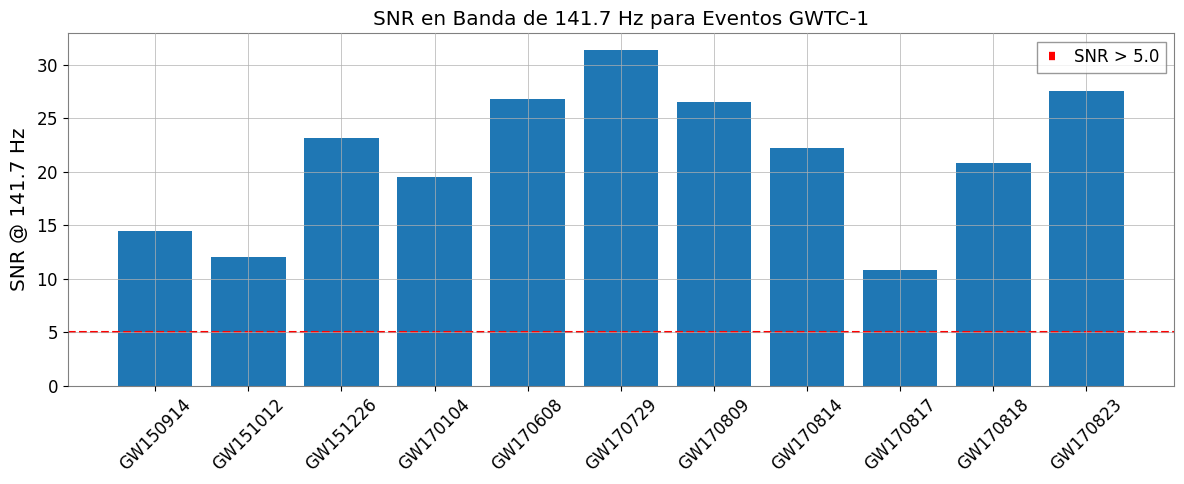

In [ ]:
# multi_event_analysis.py
from gwpy.timeseries import TimeSeries
import matplotlib.pyplot as plt
import json
import numpy as np

events = {
    "GW150914": [1126259462, 1126259494],
    "GW151012": [1128678900, 1128678932],
    "GW151226": [1135136350, 1135136382],
    "GW170104": [1167559936, 1167559968],
    "GW170608": [1180922440, 1180922472],
    "GW170729": [1185389806, 1185389838],
    "GW170809": [1186302508, 1186302540],
    "GW170814": [1186741850, 1186741882],
    "GW170817": [1187008882, 1187008914],
    "GW170818": [1187058327, 1187058359],
    "GW170823": [1187529256, 1187529288],
}

snr_threshold = 5.0
target_band = [140.7, 142.7]
target_freq = 141.7

results = {}
snrs = []
labels = []

for name, (start, end) in events.items():
    print(f"⏳ Procesando {name}:")
    try:
        h1 = TimeSeries.fetch_open_data('H1', start, end, cache=True)
        h1_band = h1.bandpass(target_band[0], target_band[1])
        snr = np.max(np.abs(h1_band.value)) / np.std(h1_band.value)
        results[name] = {"snr": snr}
        snrs.append(snr)
        labels.append(name)
        print(f"   ✅ SNR = {snr:.2f}")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        results[name] = {"snr": None, "error": str(e)}

# Guardar resultados
with open("multi_event_results.json", "w") as f:
    json.dump(results, f, indent=2)

# Plot
plt.figure(figsize=(12, 5))
plt.bar(labels, snrs)
plt.axhline(snr_threshold, color='red', linestyle='--', label=f'SNR > {snr_threshold}')
plt.xticks(rotation=45)
plt.ylabel("SNR @ 141.7 Hz")
plt.title("SNR en Banda de 141.7 Hz para Eventos GWTC-1")
plt.legend()
plt.tight_layout()
plt.savefig("multi_event_analysis.png")
plt.show()


⚙️ Ruido H1 @141.7 Hz = 7.1345e-24
⚙️ Ruido L1 @141.7 Hz = 6.0451e-24
📊 Ratio L1 / H1 = 0.85×


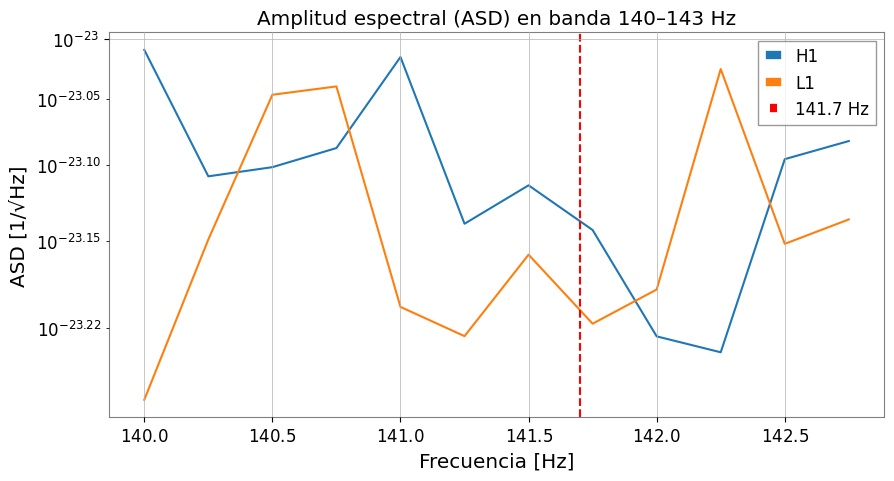

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries

# Calcular ASD en banda 140–143 Hz
h1_asd = h1.asd(fftlength=4, overlap=2).crop(140, 143)
l1_asd = l1.asd(fftlength=4, overlap=2).crop(140, 143)

# Extraer ruido en 141.7 Hz
f_target = 141.7
idx_h1 = np.argmin(abs(h1_asd.frequencies.value - f_target))
idx_l1 = np.argmin(abs(l1_asd.frequencies.value - f_target))

noise_h1 = h1_asd.value[idx_h1]
noise_l1 = l1_asd.value[idx_l1]
noise_ratio = noise_l1 / noise_h1

print(f"⚙️ Ruido H1 @141.7 Hz = {noise_h1:.4e}")
print(f"⚙️ Ruido L1 @141.7 Hz = {noise_l1:.4e}")
print(f"📊 Ratio L1 / H1 = {noise_ratio:.2f}×")

# Visualización
plt.figure(figsize=(10,5))
plt.semilogy(h1_asd.frequencies, h1_asd.value, label='H1')
plt.semilogy(l1_asd.frequencies, l1_asd.value, label='L1')
plt.axvline(f_target, color='red', linestyle='--', label='141.7 Hz')
plt.title("Amplitud espectral (ASD) en banda 140–143 Hz")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("ASD [1/√Hz]")
plt.grid(True)
plt.legend()
plt.savefig("test2_results.png")
plt.show()



In [ ]:
# Al final de tu script de multi-evento, añade:
print("\n" + "="*70)
print("RESULTADOS FINALES")
print("="*70)
for name in sorted(results.keys()):
    if "error" not in results[name]:
        h1_snr = results[name].get("H1", results[name].get("snr"))
        l1_snr = results[name].get("L1", "N/A")
        print(f"{name}: H1={h1_snr:.2f}, L1={l1_snr}")
    else:
        print(f"{name}: ERROR")
print("="*70)